#  Simple <font color=brown>GAN</font>


### see https://www.analyticsvidhya.com/blog/2017/06/introductory-generative-adversarial-networks-gans/ 

# * [MSTC](http://mstc.ssr.upm.es/big-data-track) and MUIT: <font size=5 color='green'>Deep Learning with Tensorflow & Keras</font>

---

In [1]:
# import modules
%pylab inline

import os
import numpy as np
import pandas as pd
from scipy.misc import imread

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer
from keras.regularizers import L1L2

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [0]:
# to stop potential randomness
seed = 128
rng = np.random.RandomState(seed)


In [3]:
from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [0]:
train_x = train_x / 255.

In [5]:
train_x.shape

(60000, 28, 28)

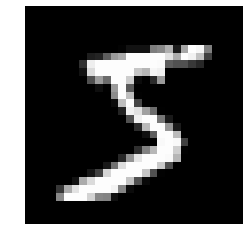

In [6]:
# print image

pylab.imshow(train_x[0], cmap='gray')
pylab.axis('off')
pylab.show()

In [0]:
# define vars
g_input_shape = 100
d_input_shape = (28, 28)
hidden_1_num_units = 500
hidden_2_num_units = 500
g_output_num_units = 784
d_output_num_units = 1
epochs = 25
batch_size = 128

In [0]:
# generator
generator = Sequential([
    Dense(units=hidden_1_num_units, input_dim=g_input_shape, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=g_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
    
    Reshape(d_input_shape),
])

# discriminator
discriminator = Sequential([
    InputLayer(input_shape=d_input_shape),
    
    Flatten(),
        
    Dense(units=hidden_1_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=d_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
])

In [9]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               392784    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 693,784
Trainable params: 693,784
Non-trainable params: 0
_________________________________________________________________


In [10]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 501       
Total params: 643,501
Trainable params: 643,501
Non-trainable params: 0
_________________________________________________________________


## Now "combine" generator and discriminator in a GAN model using Keras API

- We follow:
# https://hub.packtpub.com/generative-adversarial-networks-using-keras/


### see also:
- ### https://github.com/bstriner/keras-adversarial/blob/master/examples/example_gan.py ()problem with Keras version!)
- ### https://github.com/ussaema/Vector_Matrix_CapsuleGAN/blob/master/CapsGAN.ipynb


In [0]:
from keras.models import Model
from keras.layers import Input

z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
real = discriminator(img)
gan = Model(z, real)

In [12]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            693784    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 643501    
Total params: 1,337,285
Trainable params: 693,784
Non-trainable params: 643,501
_________________________________________________________________


---

## This is a function to save images generated into disk for every epoch

(from : https://hub.packtpub.com/generative-adversarial-networks-using-keras/)


In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
            #print(gen_imgs.shape)
            axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.close()

In [0]:
! mkdir ./images

---
## OPTIMIZERS:

NOTE:


## We’re creating two custom Adam optimizers.

- ### This is because many times we will want to change the learning rate for only the discriminator or generator, slowing one or the other down so that we end up with a stable GAN where neither is overpowering the other. You’ll also notice that we’re using beta_1 = 0.5. 

- ### This is a recommendation from the original DCGAN paper that we’ve carried forward and also had success with. A learning rate of 0.0002 is a good place to start as well, and was found in the original DCGAN paper.


In [0]:
from keras import optimizers

gen_optimizer = optimizers.Adam(lr=0.0002, beta_1=0.5)
disc_optimizer = optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer, metrics=['accuracy'])

generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

## Batches:

- ### Note that in some cases we need half true - half fake images

In [0]:
num_examples = train_x.shape[0]
num_batches = int(num_examples / float(batch_size))
half_batch = int(batch_size / 2)



---

## NOTE:

- ### We don't use `.fit` ; we need to generate and pass batches: `.train_on_batch` 

      train_on_batch() method does exactly one round of forward and backward propagation. Every time we call it, it updates the model once from the model’s previous state.
      
      
- ### Also, notice that we’re making the update for the real images and fake images separately. 
      Especially in the early stages of training, when real images and fake images are from radically different distributions, batch normalization will cause problems with training if we were to put both sets of data in the same update
      
- ### Finally to update the generator: we update the combined `gan` stack, 

In [0]:
for epoch in range(epochs + 1):
  for batch in range(num_batches):
    # noise images for the batch
    noise = np.random.normal(0, 1, (half_batch, 100))
    fake_images = generator.predict(noise)
    fake_labels = np.zeros((half_batch, 1))
  
    # real images for batch
    idx = np.random.randint(0, train_x.shape[0], half_batch)
    real_images = train_x[idx]
    real_labels = np.ones((half_batch, 1))
  
    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
  
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Train the generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

      
  # Plot the progress every and save imgaes
  print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % \
      (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))
  save_imgs(generator, epoch, batch)

In [18]:
! ls ./images

mnist_0_467.png  mnist_2_467.png  mnist_4_467.png
mnist_1_467.png  mnist_3_467.png  mnist_5_467.png


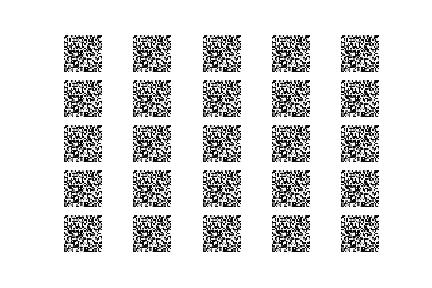

In [19]:
from IPython.display import Image
Image(filename='./images/mnist_5_467.png') 



---



---



---

